<a href="https://colab.research.google.com/github/silviacalabretta/statistical-methods-project/blob/main/022_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read and prepare the data

In [1]:
import pandas as pd
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

cols_to_drop = ['Vehicle_Bus','TimeOfDay_Night','From_Rate', 'To_Rate', 'Domestic','LogPrice']

# Apply the drops
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')
X_train.head()

,TripReason,Vehicle,NationalCode,LogLeadTime,TimeOfDay,From_Encoded,To_Encoded,Route_Encoded
0,0,0,354839990,1.310854,1,182,171,1008
1,0,1,810082118,1.517596,0,182,288,1040
2,1,2,160191252,0.375588,0,288,121,1614
3,1,1,619341352,0.743799,0,11,85,45
4,0,0,72490484,0.772156,1,288,199,1676


In [2]:
from imblearn.over_sampling import SMOTE

print("="*70)
print("STEP 1: APPLY SMOTE TO TRAINING DATA ONLY")
print("="*70)

print("\nBEFORE Oversampling (Training Data):")
print(f"Class 0 (No Cancel): {(y_train == 0).sum().iloc[0]} samples")
print(f"Class 1 (Cancel):    {(y_train == 1).sum().iloc[0]} samples")
print(f"Ratio: {((y_train == 1).sum().iloc[0] / len(y_train)) * 100:.2f}% cancellations")

# Apply SMOTE ONLY to training data
# SMOTE creates synthetic samples of the minority class (1) to match majority class (0)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAFTER Oversampling (Training Data):")
print(f"Class 0 (No Cancel): {(y_train_balanced == 0).sum().iloc[0]} samples")
print(f"Class 1 (Cancel):    {(y_train_balanced == 1).sum().iloc[0]} samples")
print(f"Ratio: {((y_train_balanced == 1).sum().iloc[0] / len(y_train_balanced)) * 100:.2f}% cancellations")


STEP 1: APPLY SMOTE TO TRAINING DATA ONLY

BEFORE Oversampling (Training Data):
Class 0 (No Cancel): 68553 samples
Class 1 (Cancel):    10911 samples
Ratio: 13.73% cancellations

AFTER Oversampling (Training Data):
Class 0 (No Cancel): 68553 samples
Class 1 (Cancel):    68553 samples
Ratio: 50.00% cancellations


In [3]:
from sklearn.preprocessing import StandardScaler
# Scale features (IMPORTANT for regularization!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Features scaled")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")


✓ Features scaled
Training data shape: (137106, 8)
Test data shape: (19866, 8)


## ELASTICNET: L1 + L2 REGULARIZATION


Elastic Net
Elastic Net penalizes the size of the regression coefficients based on both the L1 norm and L1 norm:

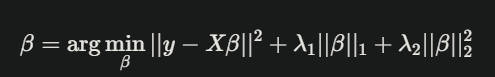

The L1 norm penalty generates a sparse model.

The L2 norm penalty:

Stabilizes the number of selected variables

Encourages grouping effect

Stabilizes the L1 regularization path

In [4]:
# ============================================
# ELASTICNET: L1 + L2 REGULARIZATION
# ============================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, f1_score, make_scorer,
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("ELASTICNET LOGISTIC REGRESSION")
print("="*70)



# Define parameter grid
# C = inverse of regularization (smaller = stronger regularization)
# l1_ratio: 0=pure L2, 1=pure L1, 0.5=equal mix
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
}

# STEP 3: Create ElasticNet model
elastic_net = LogisticRegression(
    penalty='elasticnet',
    solver='saga',  # Required for elasticnet
    max_iter=5000,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# STEP 4: GridSearchCV with F1-score optimization
print("\n⏳ Starting GridSearchCV (this may take a few minutes)...")
f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(
    elastic_net,
    param_grid,
    cv=5,
    scoring=f1_scorer,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train_balanced)

print("\n✓ GridSearch complete!")


ELASTICNET LOGISTIC REGRESSION

⏳ Starting GridSearchCV (this may take a few minutes)...
Fitting 5 folds for each of 49 candidates, totalling 245 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



✓ GridSearch complete!


In [6]:
# ============================================
# BEST MODEL & TEST EVALUATION
# ============================================

print("="*70)
print("BEST ELASTICNET MODEL")
print("="*70)
print(f"\nBest parameters found:")
print(f"  C (inverse regularization): {grid_search.best_params_['C']}")
print(f"  l1_ratio: {grid_search.best_params_['l1_ratio']}")
print(f"  Best CV F1-score: {grid_search.best_score_:.4f}")

# Interpret the parameters
C_val = grid_search.best_params_['C']
l1_val = grid_search.best_params_['l1_ratio']

print(f"\n📊 Interpretation:")
if C_val < 0.1:
    print(f"  - Strong regularization (C={C_val})")
elif C_val < 1:
    print(f"  - Moderate regularization (C={C_val})")
else:
    print(f"  - Weak regularization (C={C_val})")

if l1_val < 0.3:
    print(f"  - Mostly L2 penalty (Ridge-like, l1_ratio={l1_val})")
elif l1_val < 0.7:
    print(f"  - Balanced L1/L2 (l1_ratio={l1_val})")
else:
    print(f"  - Mostly L1 penalty (Lasso-like, l1_ratio={l1_val})")

# Get best model
best_model = grid_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

print("\n" + "="*70)
print("TEST SET PERFORMANCE")
print("="*70)
print("\nClassification Report:")
print(classification_report(y_test, y_pred,
                          target_names=['Not Cancelled', 'Cancelled']))

# Key metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 Summary Metrics:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f} (when we predict cancel, we're right {precision*100:.1f}% of time)")
print(f"  Recall:    {recall:.4f} (we catch {recall*100:.1f}% of actual cancellations)")
print(f"  F1-Score:  {f1:.4f} (harmonic mean of precision & recall)")
print(f"  ROC-AUC:   {roc_auc:.4f} (overall discriminative power)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n📋 Confusion Matrix:")
print(f"  True Negatives:  {cm[0,0]:>5} (correctly predicted no cancellation)")
print(f"  False Positives: {cm[0,1]:>5} (predicted cancel, but didn't happen) ⚠️")
print(f"  False Negatives: {cm[1,0]:>5} (missed cancellations) ❌")
print(f"  True Positives:  {cm[1,1]:>5} (correctly predicted cancellations) ✓")

print(f"\n🎯 ElasticNet:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  F1-Score: {f1:.4f}")


BEST ELASTICNET MODEL

Best parameters found:
  C (inverse regularization): 1
  l1_ratio: 0.99
  Best CV F1-score: 0.6634

📊 Interpretation:
  - Weak regularization (C=1)
  - Mostly L1 penalty (Lasso-like, l1_ratio=0.99)

TEST SET PERFORMANCE

Classification Report:
               precision    recall  f1-score   support

Not Cancelled       0.88      0.66      0.76     17138
    Cancelled       0.18      0.45      0.25      2728

     accuracy                           0.63     19866
    macro avg       0.53      0.56      0.50     19866
 weighted avg       0.79      0.63      0.69     19866


📊 Summary Metrics:
  Accuracy:  0.6323
  Precision: 0.1753 (when we predict cancel, we're right 17.5% of time)
  Recall:    0.4527 (we catch 45.3% of actual cancellations)
  F1-Score:  0.2527 (harmonic mean of precision & recall)
  ROC-AUC:   0.5756 (overall discriminative power)

📋 Confusion Matrix:
  True Negatives:  11327 (correctly predicted no cancellation)
  False Positives:  5811 (predicte

In [7]:
# ============================================
# FEATURE IMPORTANCE (Coefficients)
# ============================================

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_[0]
})

# Sort by absolute value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Count non-zero coefficients
n_features_selected = (coefficients['Coefficient'] != 0).sum()
n_features_removed = (coefficients['Coefficient'] == 0).sum()

print(f"\n📈 L1 Regularization Feature Selection:")
print(f"  Total features: {len(coefficients)}")
print(f"  Features kept: {n_features_selected}")
print(f"  Features removed: {n_features_removed}")
if n_features_removed > 0:
    print(f"  Reduction: {n_features_removed/len(coefficients)*100:.1f}%")

print(f"\n🔝 TOP FEATURES (by importance):")
print(coefficients[coefficients['Coefficient'] != 0][['Feature', 'Coefficient']].head(15).to_string(index=False))

# Show which features were completely removed
if n_features_removed > 0:
    removed_features = coefficients[coefficients['Coefficient'] == 0]['Feature'].tolist()
    print(f"\n❌ Features REMOVED (coefficient = 0):")
    for feat in removed_features:
        print(f"  - {feat}")
else:
    print("\n✓ All features were kept (none removed by L1)")

# Interpretation
print("\n💡 Interpretation:")
print("  - Positive coefficient = increases cancellation probability")
print("  - Negative coefficient = decreases cancellation probability")
print("  - Larger absolute value = stronger effect")


FEATURE IMPORTANCE ANALYSIS

📈 L1 Regularization Feature Selection:
  Total features: 8
  Features kept: 8
  Features removed: 0

🔝 TOP FEATURES (by importance):
      Feature  Coefficient
Route_Encoded     0.807389
 From_Encoded    -0.747264
      Vehicle    -0.674511
  LogLeadTime     0.578966
   TripReason    -0.347860
    TimeOfDay    -0.295066
   To_Encoded     0.036330
 NationalCode    -0.009517

✓ All features were kept (none removed by L1)

💡 Interpretation:
  - Positive coefficient = increases cancellation probability
  - Negative coefficient = decreases cancellation probability
  - Larger absolute value = stronger effect


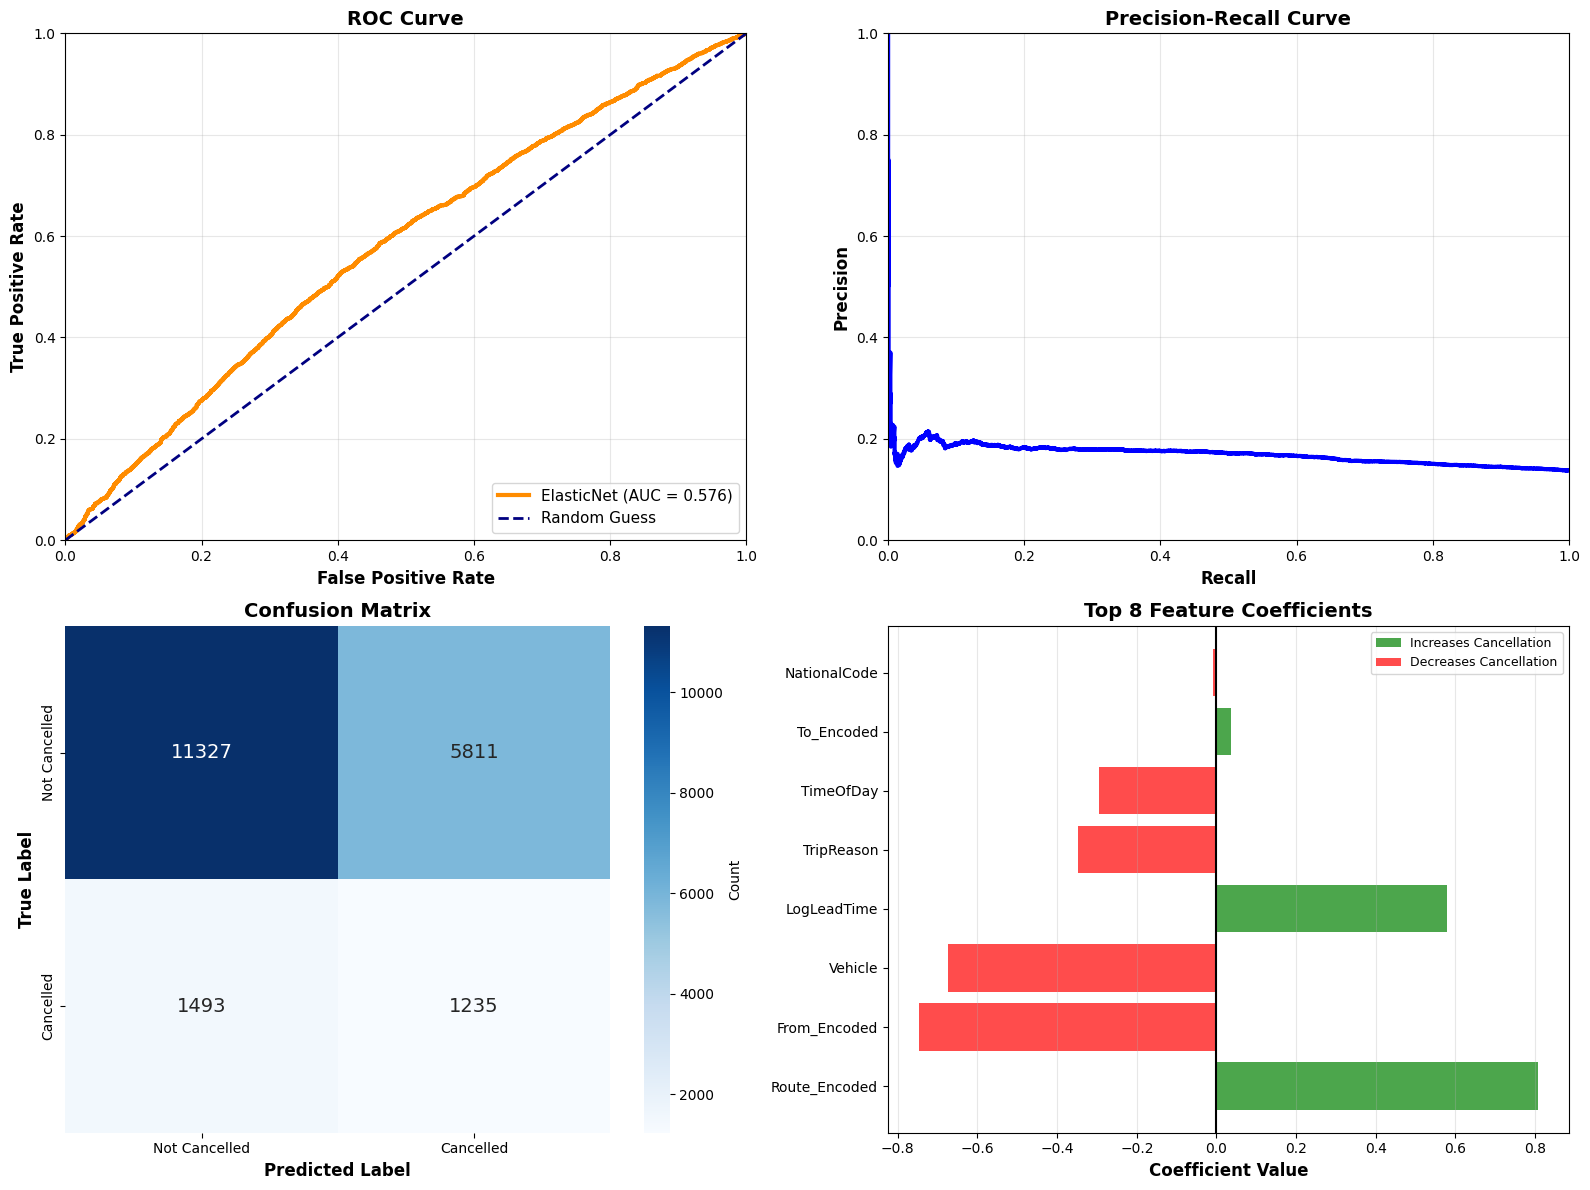


✓ Visualizations complete!


In [8]:
# ============================================
# VISUALIZATIONS
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

axes[0, 0].plot(fpr, tpr, color='darkorange', lw=3,
                label=f'ElasticNet (AUC = {roc_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0, 0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend(loc="lower right", fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, 1])
axes[0, 0].set_ylim([0, 1])

# 2. Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

axes[0, 1].plot(recall_vals, precision_vals, color='blue', lw=3)
axes[0, 1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])

# 3. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Not Cancelled', 'Cancelled'],
            yticklabels=['Not Cancelled', 'Cancelled'],
            cbar_kws={'label': 'Count'}, annot_kws={'size': 14})
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 4. Feature Coefficients (only non-zero)
top_features = coefficients[coefficients['Coefficient'] != 0].head(min(15, n_features_selected))
colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]

axes[1, 1].barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'], fontsize=10)
axes[1, 1].set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
axes[1, 1].set_title(f'Top {len(top_features)} Feature Coefficients', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='black', linestyle='-', linewidth=1.5)
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='green', alpha=0.7, label='Increases Cancellation'),
                   Patch(facecolor='red', alpha=0.7, label='Decreases Cancellation')]
axes[1, 1].legend(handles=legend_elements, loc='best', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")


FINDING OPTIMAL PROBABILITY THRESHOLD

Problem: Default threshold (0.5) causes too many false positives
Solution: Find threshold that balances precision and recall

Threshold Optimization Results:
 Threshold  Precision   Recall  F1-Score
      0.30   0.150253 0.804252  0.253203
      0.35   0.155098 0.726540  0.255626
      0.40   0.162485 0.643328  0.259443
      0.45   0.169577 0.551686  0.259416
      0.50   0.175277 0.452713  0.252711
      0.55   0.176640 0.359238  0.236829
      0.60   0.180913 0.273094  0.217645
      0.65   0.180062 0.191349  0.185534
      0.70   0.196552 0.125367  0.153089
      0.75   0.204036 0.066716  0.100552

OPTIMAL THRESHOLD FOUND
🎯 Best threshold: 0.40 (instead of default 0.5)

   F1-Score:  0.2594
   Precision: 0.1625
   Recall:    0.6433

📋 Optimized Confusion Matrix (threshold=0.40):
  True Negatives:   8092 (correctly predicted no cancellation)
  False Positives:  9046 (false alarms) ⚠️
  False Negatives:   973 (missed cancellations) ❌
  True Posi

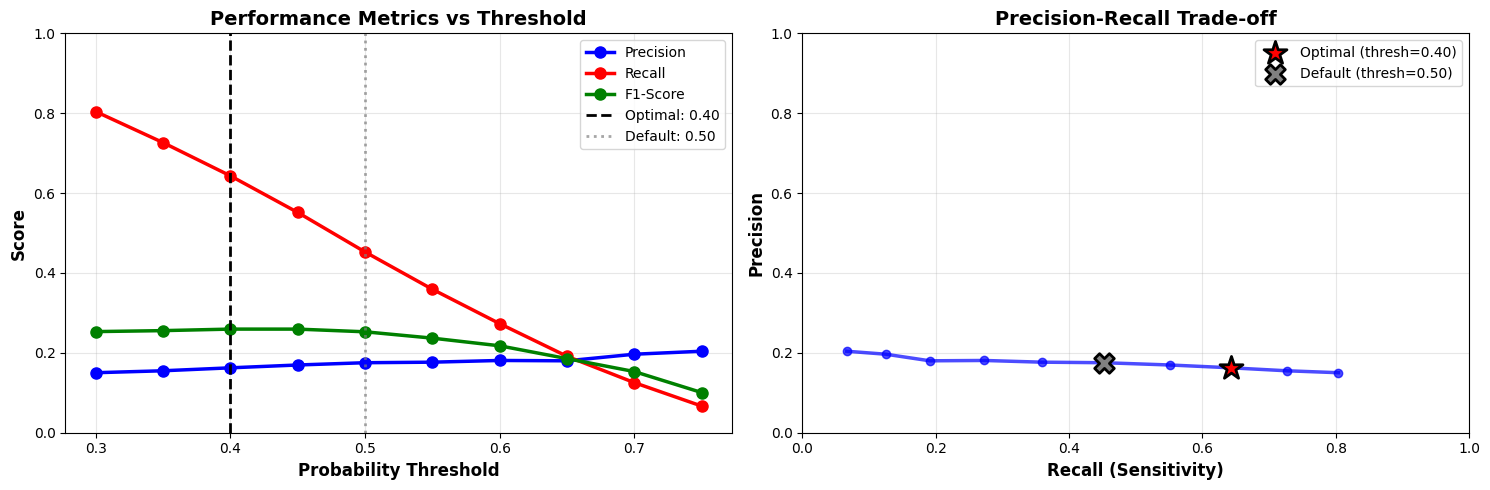


✓ Threshold optimization complete!


In [9]:
# ============================================
# THRESHOLD OPTIMIZATION
# ============================================
import numpy as np
print("="*70)
print("FINDING OPTIMAL PROBABILITY THRESHOLD")
print("="*70)
print("\nProblem: Default threshold (0.5) causes too many false positives")
print("Solution: Find threshold that balances precision and recall\n")

# Try different thresholds
thresholds = np.arange(0.3, 0.8, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    # Skip if no predictions of class 1
    if y_pred_thresh.sum() == 0:
        continue

    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)

    results.append({
        'Threshold': thresh,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

results_df = pd.DataFrame(results)
print("Threshold Optimization Results:")
print(results_df.to_string(index=False))

# Find best threshold (maximize F1)
best_idx = results_df['F1-Score'].idxmax()
best_thresh = results_df.loc[best_idx, 'Threshold']

print(f"\n{'='*70}")
print("OPTIMAL THRESHOLD FOUND")
print(f"{'='*70}")
print(f"🎯 Best threshold: {best_thresh:.2f} (instead of default 0.5)")
print(f"\n   F1-Score:  {results_df.loc[best_idx, 'F1-Score']:.4f}")
print(f"   Precision: {results_df.loc[best_idx, 'Precision']:.4f}")
print(f"   Recall:    {results_df.loc[best_idx, 'Recall']:.4f}")

# Apply best threshold
y_pred_optimized = (y_pred_proba >= best_thresh).astype(int)
cm_optimized = confusion_matrix(y_test, y_pred_optimized)

print(f"\n📋 Optimized Confusion Matrix (threshold={best_thresh:.2f}):")
print(f"  True Negatives:  {cm_optimized[0,0]:>5} (correctly predicted no cancellation)")
print(f"  False Positives: {cm_optimized[0,1]:>5} (false alarms) ⚠️")
print(f"  False Negatives: {cm_optimized[1,0]:>5} (missed cancellations) ❌")
print(f"  True Positives:  {cm_optimized[1,1]:>5} (caught cancellations) ✓")

# Compare to default threshold
print(f"\n📊 Improvement over default (0.5):")
print(f"  False Positives: {cm[0,1]} → {cm_optimized[0,1]} "
      f"(reduced by {cm[0,1] - cm_optimized[0,1]})")
print(f"  Precision: {precision:.3f} → {results_df.loc[best_idx, 'Precision']:.3f} "
      f"(+{(results_df.loc[best_idx, 'Precision'] - precision)*100:.1f}%)")

# Visualize threshold optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Metrics vs Threshold
axes[0].plot(results_df['Threshold'], results_df['Precision'],
             'b-o', label='Precision', linewidth=2.5, markersize=8)
axes[0].plot(results_df['Threshold'], results_df['Recall'],
             'r-o', label='Recall', linewidth=2.5, markersize=8)
axes[0].plot(results_df['Threshold'], results_df['F1-Score'],
             'g-o', label='F1-Score', linewidth=2.5, markersize=8)
axes[0].axvline(best_thresh, color='black', linestyle='--', linewidth=2,
                label=f'Optimal: {best_thresh:.2f}')
axes[0].axvline(0.5, color='gray', linestyle=':', linewidth=2,
                label='Default: 0.50', alpha=0.7)
axes[0].set_xlabel('Probability Threshold', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# Plot 2: Precision-Recall Trade-off
axes[1].plot(results_df['Recall'], results_df['Precision'],
             'b-o', linewidth=2.5, markersize=6, alpha=0.7)
axes[1].scatter(results_df.loc[best_idx, 'Recall'],
                results_df.loc[best_idx, 'Precision'],
                color='red', s=300, marker='*',
                label=f'Optimal (thresh={best_thresh:.2f})',
                zorder=5, edgecolors='black', linewidths=2)
# Mark default threshold (0.5)
default_idx = (results_df['Threshold'] - 0.5).abs().idxmin()
axes[1].scatter(results_df.loc[default_idx, 'Recall'],
                results_df.loc[default_idx, 'Precision'],
                color='gray', s=200, marker='X',
                label=f'Default (thresh=0.50)',
                zorder=4, edgecolors='black', linewidths=2)
axes[1].set_xlabel('Recall (Sensitivity)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Threshold optimization complete!")


FINAL MODEL COMPARISON (CORRECTED)
                      Model  ROC-AUC  F1-Score  Precision   Recall  Accuracy
 ElasticNet (threshold=0.5)  0.57561  0.252711   0.175277 0.452713  0.632337
ElasticNet (threshold=0.40)  0.57561  0.259443   0.162485 0.643328  0.495671

📈 Default (0.5) → Optimized (0.40):
  F1-Score:  0.2527 → 0.2594 (+2.7%)
  Precision: 0.1753 → 0.1625 (-7.3%)
  Recall:    0.4527 → 0.6433 (+42.1%)

💡 Trade-off: Optimized threshold sacrifices some precision for better recall


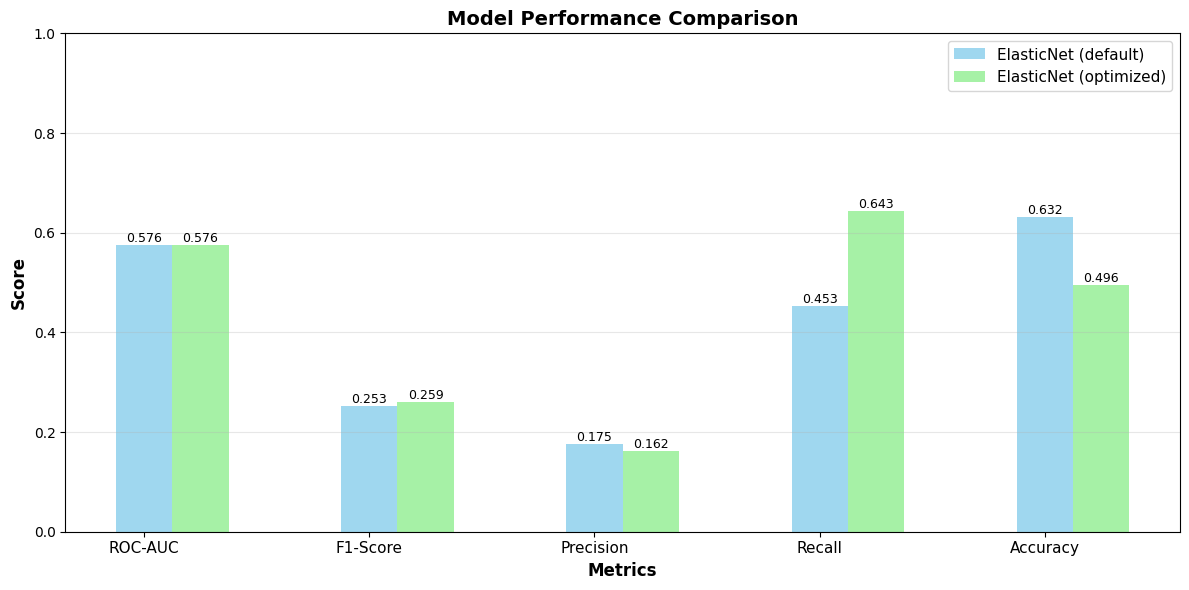

In [10]:
# ============================================
# FINAL MODEL COMPARISON TABLE (CORRECTED)
# ============================================

# Calculate metrics for all models

# FIXED: Use correct default threshold (0.5) metrics
default_idx = (results_df['Threshold'] - 0.5).abs().idxmin()
elasticnet_default = {
    'Model': 'ElasticNet (threshold=0.5)',
    'ROC-AUC': roc_auc,
    'F1-Score': results_df.loc[default_idx, 'F1-Score'],
    'Precision': results_df.loc[default_idx, 'Precision'],
    'Recall': results_df.loc[default_idx, 'Recall'],
    'Accuracy': accuracy_score(y_test, (y_pred_proba >= 0.5).astype(int))
}

elasticnet_optimized = {
    'Model': f'ElasticNet (threshold={best_thresh:.2f})',
    'ROC-AUC': roc_auc,
    'F1-Score': results_df.loc[best_idx, 'F1-Score'],
    'Precision': results_df.loc[best_idx, 'Precision'],
    'Recall': results_df.loc[best_idx, 'Recall'],
    'Accuracy': accuracy_score(y_test, y_pred_optimized)
}

# Create comparison dataframe
comparison_df = pd.DataFrame([elasticnet_default, elasticnet_optimized])

print("="*70)
print("FINAL MODEL COMPARISON (CORRECTED)")
print("="*70)
print(comparison_df.to_string(index=False))

# Highlight improvements
print(f"\n📈 Default (0.5) → Optimized ({best_thresh:.2f}):")
print(f"  F1-Score:  {elasticnet_default['F1-Score']:.4f} → {elasticnet_optimized['F1-Score']:.4f} "
      f"(+{(elasticnet_optimized['F1-Score']-elasticnet_default['F1-Score'])/elasticnet_default['F1-Score']*100:.1f}%)")
print(f"  Precision: {elasticnet_default['Precision']:.4f} → {elasticnet_optimized['Precision']:.4f} "
      f"({(elasticnet_optimized['Precision']-elasticnet_default['Precision'])/elasticnet_default['Precision']*100:+.1f}%)")
print(f"  Recall:    {elasticnet_default['Recall']:.4f} → {elasticnet_optimized['Recall']:.4f} "
      f"({(elasticnet_optimized['Recall']-elasticnet_default['Recall'])/elasticnet_default['Recall']*100:+.1f}%)")

print("\n💡 Trade-off: Optimized threshold sacrifices some precision for better recall")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['ROC-AUC', 'F1-Score', 'Precision', 'Recall', 'Accuracy']
x = np.arange(len(metrics))
width = 0.25


bars1 = ax.bar(x, comparison_df.iloc[0][metrics], width,
               label='ElasticNet (default)', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width, comparison_df.iloc[1][metrics], width,
               label='ElasticNet (optimized)', alpha=0.8, color='lightgreen')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(fontsize=11)
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

#Random Forest

RANDOM FOREST CLASSIFIER

⏳ Training Random Forest...


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✓ Training complete in 11.6 seconds

RANDOM FOREST PERFORMANCE

🎯 Metrics (threshold=0.5):
   ROC-AUC:   0.6497
   F1-Score:  0.1850
   Precision: 0.2350
   Recall:    0.1525
   Accuracy:  0.8155

📋 Confusion Matrix:
  TN: 15784  |  FP:  1354
  FN:  2312  |  TP:   416

FINDING OPTIMAL THRESHOLD

🎯 Best threshold: 0.35
   F1-Score:  0.2861
   Precision: 0.2196
   Recall:    0.4102

📋 Optimized Confusion Matrix:
  TN: 13162  |  FP:  3976
  FN:  1609  |  TP:  1119

FEATURE IMPORTANCE


      Feature  Importance
 From_Encoded    0.218465
   To_Encoded    0.202725
Route_Encoded    0.185867
  LogLeadTime    0.174432
      Vehicle    0.085018
   TripReason    0.050582
 NationalCode    0.043480
    TimeOfDay    0.039431


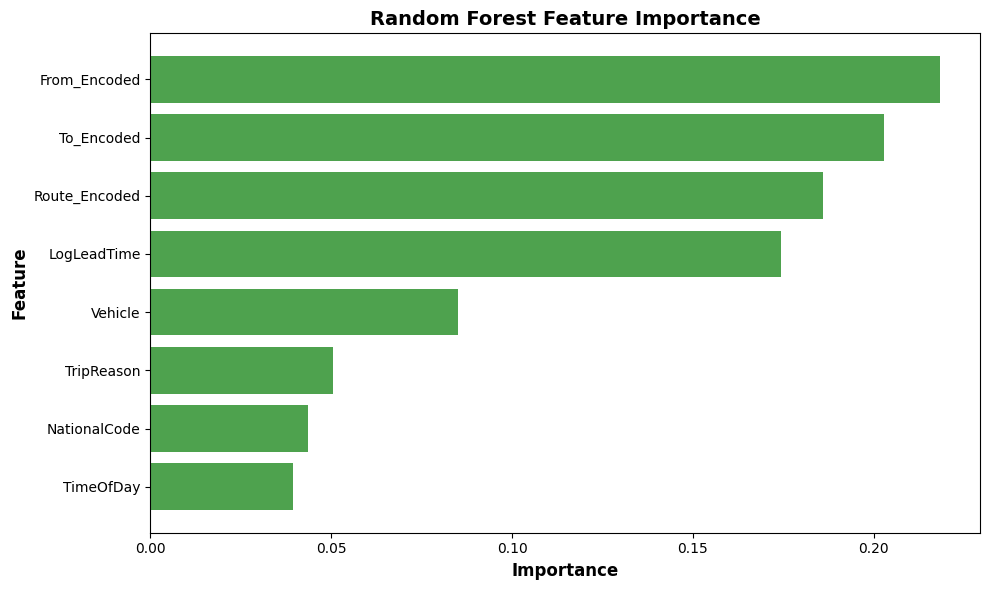


✅ Random Forest analysis complete!


In [11]:
# ============================================
# RANDOM FOREST CLASSIFIER
# ============================================

from sklearn.ensemble import RandomForestClassifier
import time

print("="*70)
print("RANDOM FOREST CLASSIFIER")
print("="*70)

# Train Random Forest with good default parameters
print("\n⏳ Training Random Forest...")

start_time = time.time()

# Simple model with balanced class weights
rf_model = RandomForestClassifier(
    n_estimators=100,              # 100 trees (good balance of speed/accuracy)
    max_depth=15,                  # Limit depth to prevent overfitting
    min_samples_split=10,          # Need 10 samples to split a node
    min_samples_leaf=4,            # Need 4 samples at each leaf
    class_weight='balanced',       # Handle class imbalance automatically
    random_state=42,
    n_jobs=-1,                     # Use all CPU cores
    verbose=0
)

rf_model.fit(X_train_scaled, y_train_balanced)

elapsed_time = time.time() - start_time
print(f"✓ Training complete in {elapsed_time:.1f} seconds")

# ============================================
# EVALUATE ON TEST SET
# ============================================

print("\n" + "="*70)
print("RANDOM FOREST PERFORMANCE")
print("="*70)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics (default threshold 0.5)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"\n🎯 Metrics (threshold=0.5):")
print(f"   ROC-AUC:   {roc_auc_rf:.4f}")
print(f"   F1-Score:  {f1_rf:.4f}")
print(f"   Precision: {precision_rf:.4f}")
print(f"   Recall:    {recall_rf:.4f}")
print(f"   Accuracy:  {accuracy_rf:.4f}")

print(f"\n📋 Confusion Matrix:")
print(f"  TN: {cm_rf[0,0]:>5}  |  FP: {cm_rf[0,1]:>5}")
print(f"  FN: {cm_rf[1,0]:>5}  |  TP: {cm_rf[1,1]:>5}")

# ============================================
# THRESHOLD OPTIMIZATION
# ============================================

print("\n" + "="*70)
print("FINDING OPTIMAL THRESHOLD")
print("="*70)

# Test only 5 thresholds (faster)
thresholds_rf = [0.35, 0.40, 0.45, 0.50, 0.55]
best_f1 = 0
best_thresh_rf = 0.5

for thresh in thresholds_rf:
    y_pred_thresh = (y_pred_proba_rf >= thresh).astype(int)
    if y_pred_thresh.sum() == 0:
        continue
    f1_t = f1_score(y_test, y_pred_thresh)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_thresh_rf = thresh

y_pred_optimized_rf = (y_pred_proba_rf >= best_thresh_rf).astype(int)
precision_opt_rf = precision_score(y_test, y_pred_optimized_rf)
recall_opt_rf = recall_score(y_test, y_pred_optimized_rf)
cm_opt_rf = confusion_matrix(y_test, y_pred_optimized_rf)

print(f"\n🎯 Best threshold: {best_thresh_rf:.2f}")
print(f"   F1-Score:  {best_f1:.4f}")
print(f"   Precision: {precision_opt_rf:.4f}")
print(f"   Recall:    {recall_opt_rf:.4f}")

print(f"\n📋 Optimized Confusion Matrix:")
print(f"  TN: {cm_opt_rf[0,0]:>5}  |  FP: {cm_opt_rf[0,1]:>5}")
print(f"  FN: {cm_opt_rf[1,0]:>5}  |  TP: {cm_opt_rf[1,1]:>5}")

# ============================================
# FEATURE IMPORTANCE
# ============================================

print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n")
print(feature_importance.to_string(index=False))

# Simple bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'],
         color='forestgreen', alpha=0.8)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✅ Random Forest analysis complete!")


In [ ]:
# ============================================
# RANDOM FOREST MODEL
# ============================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import time

print("="*70)
print("RANDOM FOREST CLASSIFIER WITH CLASS IMBALANCE HANDLING")
print("="*70)

# Note: Random Forest doesn't need scaled features, so use original X_train_res
# But since we already have scaled versions, we can use them (won't hurt)

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees
    'max_depth': [10, 15, 20, None],           # Tree depth
    'min_samples_split': [2, 5, 10],           # Min samples to split node
    'min_samples_leaf': [1, 2, 4],             # Min samples at leaf
    'max_features': ['sqrt', 'log2', None],    # Features per split
    'class_weight': ['balanced', 'balanced_subsample'],  # Handle imbalance
    'bootstrap': [True],                       # Use bootstrap samples
}

print(f"\n🔧 Hyperparameter Grid: {len(rf_param_grid['n_estimators']) * len(rf_param_grid['max_depth']) * len(rf_param_grid['min_samples_split']) * len(rf_param_grid['min_samples_leaf']) * len(rf_param_grid['max_features']) * len(rf_param_grid['class_weight'])} combinations")

# Use RandomizedSearchCV (faster than GridSearchCV for large grids)
print("\n⏳ Training Random Forest with RandomizedSearchCV...")
print("   (This may take 2-3 minutes...)")

start_time = time.time()

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,                    # Try 50 random combinations
    cv=5,                         # 5-fold cross-validation
    scoring='roc_auc',            # Optimize for ROC-AUC
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_random_search.fit(X_train_scaled, y_train_balanced)

elapsed_time = time.time() - start_time
print(f"\n✓ Training complete in {elapsed_time:.1f} seconds ({elapsed_time/60:.1f} minutes)")

# Best model
best_rf = rf_random_search.best_estimator_

print("\n" + "="*70)
print("BEST RANDOM FOREST PARAMETERS")
print("="*70)
for param, value in rf_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n📊 Best CV ROC-AUC Score: {rf_random_search.best_score_:.4f}")

# ============================================
# EVALUATE RANDOM FOREST ON TEST SET
# ============================================

print("\n" + "="*70)
print("RANDOM FOREST PERFORMANCE ON TEST SET")
print("="*70)

# Predictions
y_pred_rf = best_rf.predict(X_test_scaled)
y_pred_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics (default threshold 0.5)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"\n🎯 ROC-AUC Score: {roc_auc_rf:.4f}")
print(f"   Accuracy:      {accuracy_rf:.4f}")
print(f"   Precision:     {precision_rf:.4f}")
print(f"   Recall:        {recall_rf:.4f}")
print(f"   F1-Score:      {f1_rf:.4f}")

print(f"\n📋 Confusion Matrix (threshold=0.5):")
print(f"  True Negatives:  {cm_rf[0,0]:>5}")
print(f"  False Positives: {cm_rf[0,1]:>5}")
print(f"  False Negatives: {cm_rf[1,0]:>5}")
print(f"  True Positives:  {cm_rf[1,1]:>5}")

# ============================================
# THRESHOLD OPTIMIZATION FOR RANDOM FOREST
# ============================================

print("\n" + "="*70)
print("THRESHOLD OPTIMIZATION FOR RANDOM FOREST")
print("="*70)

thresholds_rf = np.arange(0.3, 0.8, 0.05)
results_rf = []

for thresh in thresholds_rf:
    y_pred_thresh_rf = (y_pred_proba_rf >= thresh).astype(int)

    if y_pred_thresh_rf.sum() == 0:
        continue

    precision_t = precision_score(y_test, y_pred_thresh_rf)
    recall_t = recall_score(y_test, y_pred_thresh_rf)
    f1_t = f1_score(y_test, y_pred_thresh_rf)

    results_rf.append({
        'Threshold': thresh,
        'Precision': precision_t,
        'Recall': recall_t,
        'F1-Score': f1_t
    })

results_rf_df = pd.DataFrame(results_rf)
print("\nThreshold Optimization Results:")
print(results_rf_df.to_string(index=False))

best_idx_rf = results_rf_df['F1-Score'].idxmax()
best_thresh_rf = results_rf_df.loc[best_idx_rf, 'Threshold']

print(f"\n🎯 Best threshold: {best_thresh_rf:.2f}")
print(f"   F1-Score:  {results_rf_df.loc[best_idx_rf, 'F1-Score']:.4f}")
print(f"   Precision: {results_rf_df.loc[best_idx_rf, 'Precision']:.4f}")
print(f"   Recall:    {results_rf_df.loc[best_idx_rf, 'Recall']:.4f}")

# Apply best threshold
y_pred_optimized_rf = (y_pred_proba_rf >= best_thresh_rf).astype(int)
cm_optimized_rf = confusion_matrix(y_test, y_pred_optimized_rf)

print(f"\n📋 Optimized Confusion Matrix (threshold={best_thresh_rf:.2f}):")
print(f"  True Negatives:  {cm_optimized_rf[0,0]:>5}")
print(f"  False Positives: {cm_optimized_rf[0,1]:>5}")
print(f"  False Negatives: {cm_optimized_rf[1,0]:>5}")
print(f"  True Positives:  {cm_optimized_rf[1,1]:>5}")

# ============================================
# FEATURE IMPORTANCE FROM RANDOM FOREST
# ============================================

print("\n" + "="*70)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*70)

# Get feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop Features by Importance:")
print(feature_importance_rf.to_string(index=False))

# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='forestgreen', alpha=0.8)
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n✓ Random Forest training complete!")


RANDOM FOREST CLASSIFIER WITH CLASS IMBALANCE HANDLING

🔧 Hyperparameter Grid: 648 combinations

⏳ Training Random Forest with RandomizedSearchCV...
   (This may take 2-3 minutes...)
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


#XGBoost

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
sns.set(style= "darkgrid", color_codes = True)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define the XGBoost model
model = XGBClassifier()

# Define the hyperparameters to be tuned
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.5],
    'colsample_bylevel' : [0.1, 0.2, 0.3, 0.5],
    'min_child_weight': [1, 3, 5,7],
}


# Perform grid search to find the best hyperparameters
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid=param_grid, cv=kfold, n_jobs=-1)
grid_search.fit(X_train_scaled,y_train_balanced)

# Print the best hyperparameters and the corresponding score
print("Best score: {:.4f}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

In [ ]:
# setup hyperparameters for XGBClassifier
model = XGBClassifier(booster= 'gbtree', learning_rate= 0.1, max_depth= 5, n_estimators=150, colsample_bylevel= 0.5, colsample_bytree=0.5, min_child_weight=1)
model.fit(X_train_scaled, y_train_balanced)
y_pred = model.predict(X_test_scaled)

# define the evaluation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# evaluate the model on the dataset
n_scores = cross_val_score(model, X_train_scaled, y_train_balanced, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
print("Accuracy score (training): {0:.3f}".format(model.score(X_train_scaled, y_train_balanced)))
print("Accuracy score (validation): {0:.3f}".format(model.score(X_train_scaled, y_test)))